# We reproduce results from section 6.4.2 in 'Spectroscopic Ellipsometry', by H. Fujiwara
Author: O. Castany, M. Müller

Verification of the internal functions of the PyElli code against results presented in Fujiwara's book
p. 241 (section 6.4.2). References in the comments refer to this book.
Expected results are indicated after the commands. They are identical
with Fujiwara's results, except for a sign convention for Erp.

We simulate an air / anisotropic thin film / silicon substrate system and calculate:
- The permittivity tensor of the anisotropic film
- The Delta Matrix and its eigenvalues
- The propagation matrix for the film
- The Jones reflection matrix
- The ellipsometric parameters Ψ and Δ
- Full angular dependences of Ψ_pp, Ψ_ps, Δ_pp, and Δ_ps as shown in Figure 6.19

In [1]:
import numpy as np
import elli
from scipy.constants import pi
import matplotlib.pyplot as pyplot
import scipy.linalg

# reduces the number of printed figures in numbers:
np.set_printoptions(suppress=True, precision=4)

## Define the Sample: Air / anisotropic film / silicon substrate

In [2]:
n_i = 1.0   # Incident medium: air
n_o = 2.0   # Ordinary index of the uniaxial film
n_e = 2.5   # Extraordinary index of the uniaxial film
lbda = 620  # Wavelength (nm)
Phi_i = 70  # Angle of incidence (degrees)
d = 100     # Layer thickness (nm)

# Euler angles for optical axis orientation of the film
Phi_E = 45  # 1st Euler angle (azimuth)
Theta_E = 45  # 2nd Euler angle (tilt)

## Permittivity tensor of the anisotropic film (eq 6.63, p. 241):

In [3]:
filmMaterial = elli.UniaxialMaterial(
    elli.ConstantRefractiveIndex(n_o), elli.ConstantRefractiveIndex(n_e)
)
R = elli.rotation_euler(Phi_E, Theta_E, 0)
filmMaterial.set_rotation(R)
print(filmMaterial.get_tensor(lbda))

[[[ 4.5625+0.j -0.5625+0.j  0.7955+0.j]
  [-0.5625+0.j  4.5625+0.j -0.7955+0.j]
  [ 0.7955+0.j -0.7955+0.j  5.125 +0.j]]]


Expected output:
```python
[[[ 4.5625, -0.5625,  0.7955],
  [-0.5625,  4.5625, -0.7955],
  [ 0.7955, -0.7955,  5.125 ]]]
```

## In-Plane Wavevector Component (Kx)

In [4]:
air = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(n_i))
Kx = n_i * np.sin(np.deg2rad(Phi_i))

print("Kx: {:.4f}".format(Kx))

Kx: 0.9397


Expected output:
```python
Kx = 0.9397
```

## Delta matrix (Δ_B) and it's Eigenvalues (eq 6.64, p.241)

In [5]:
film = elli.Layer(filmMaterial, d)
epsilon = filmMaterial.get_tensor(lbda)
Delta = elli.Solver4x4.build_delta_matrix(Kx, epsilon)
print("\nDelta matrix:")
print(Delta)

q, Psi = scipy.linalg.eig(Delta[0])
print("\nEigenvalues of the Delta matrix:")
print(np.real(q))


Delta matrix:
[[[-0.1459+0.j  0.1459-0.j  0.    +0.j  0.8277+0.j]
  [ 0.    +0.j  0.    +0.j -1.    +0.j  0.    +0.j]
  [ 0.439 +0.j -3.556 +0.j  0.    +0.j -0.1459+0.j]
  [ 4.439 +0.j -0.439 +0.j  0.    +0.j -0.1459+0.j]]]

Eigenvalues of the Delta matrix:
[-2.174  -1.7655  1.7655  1.8822]


Expected output:
```python
# Delta matrix:
[[[-0.1459,  0.1459,  0.    ,  0.8277],
  [ 0.    ,  0.    , -1.    ,  0.    ],
  [ 0.439 , -3.556 ,  0.    , -0.1459],
  [ 4.439 , -0.439 ,  0.    , -0.1459]]]

# Eigenvalues of Delta
[-2.174 , -1.7655,  1.7655,  1.8822]
```

## Propagation Matrix (T_p, eq 6.66, p. 242)

In [6]:
Tp = elli.PropagatorExpm().calculate_propagation(Delta, -d, np.array([lbda]))
print("\nPropagation matrix:")
print(Tp)


Propagation matrix:
[[[-0.3516-0.0572j  0.0906-0.001j   0.0334+0.0437j  0.0561-0.3971j]
  [ 0.1042+0.0795j -0.3258-0.0114j  0.0037+0.5017j -0.0334-0.0437j]
  [ 0.1617-0.0145j -0.0166+1.7533j -0.3258-0.0114j -0.0906+0.001j ]
  [ 0.3001-2.1207j -0.1617+0.0145j -0.1042-0.0795j -0.3516-0.0572j]]]


Expected output:
```python
[[[-0.353-0.057j,  0.091-0.001j,  0.033+0.044j,  0.056-0.397j],
  [ 0.104+0.08j , -0.327-0.011j,  0.004+0.502j, -0.033-0.044j],
  [ 0.162-0.014j, -0.017+1.753j, -0.327-0.011j, -0.091+0.001j],
  [ 0.300-2.12j , -0.162+0.014j, -0.104-0.08j , -0.353-0.057j]]]
```

## Full Stack: Air / Anisotropic Film / Silicon

In [7]:
n_t = 3.898 + 0.016j  # Substrate refractive index (Si at 620 nm)
silicon = elli.ConstantRefractiveIndex(n_t).get_mat()
s = elli.Structure(air, [film], silicon)
result = s.evaluate(np.array([lbda]), Phi_i)

## Jones Reflection Matrix and Ellipsometry Parameters

In [8]:
Jr = result.jones_matrix_r
print("\nJones reflexion matrix:")
print(Jr)

print("\nEllipsometry parameters:")
(Psi, Delta) = (result.psi_matrix, result.delta_matrix)
print("Psi\n" + str(Psi))
print("Delta\n" + str(Delta))


Jones reflexion matrix:
[[[-0.3107-0.1606j -0.1067-0.0019j]
  [ 0.0422-0.0359j -0.5512+0.1507j]]]

Ellipsometry parameters:
Psi
[[[31.4728 10.5742]
  [ 5.5361 45.    ]]]
Delta
[[[ -42.629   -16.3048]
  [-154.8662    0.    ]]]


Expected output:
```python
Jr =
[[[ 0.310+0.161j,  0.107+0.002j],
  [ 0.042-0.036j, -0.552+0.151j]]]
```
The first line, [r_pp, r_ps], has reversed sign compared to Fujiwara's result, due to the different convention for Erp.

Ellipsometry parameters:
```python
Psi                         Delta
[[ 31.4419  10.5641]         [[ -42.734   -16.4123]
 [  5.5332  45.    ]]         [-155.024     0.    ]]
```

## Reproducing Figure 6.19: Ψ and Δ vs. Φ_E

This figure shows the dependence of Ψ and Δ on the azimuthal orientation Φ_E of the anisotropic film for different tilt angles Θ_E.

### Angular Sweep and Data Collection

In [9]:
Theta_E_list = [0, 45, 90]
Phi_E_list = np.linspace(0, 180, 36 * 2 + 1)

data = elli.ResultList()

for Theta_E in Theta_E_list:
    for Phi_E in Phi_E_list:
        R = elli.rotation_euler(Phi_E, Theta_E, 0)
        filmMaterial.set_rotation(R)
        data.append(s.evaluate(np.array([lbda]), Phi_i))

### Reshape Results for Plotting

In [10]:
psi_pp = data.psi_pp.reshape(3, 73).T
psi_ps = data.psi_ps.reshape(3, 73).T

delta_pp = data.delta_pp.reshape(3, 73).T
delta_ps = data.delta_ps.reshape(3, 73).T

### Plotting Figure 6.19

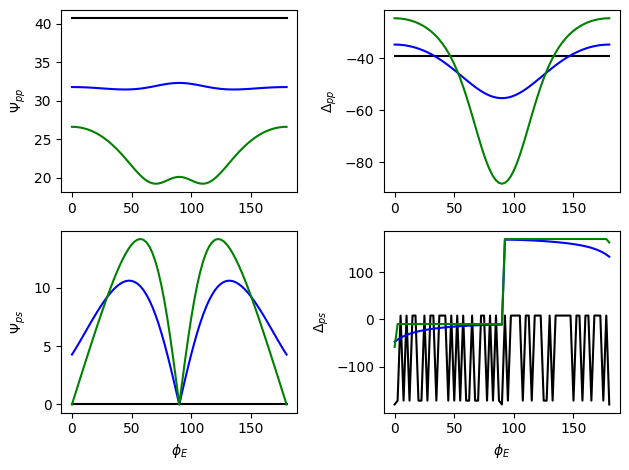

In [11]:
fig = pyplot.figure()
# Plot curves for the three values of Theta_E
pyplot.rcParams["axes.prop_cycle"] = pyplot.cycler("color", "kbg")
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(Phi_E_list, psi_pp)
ax1.set_ylabel(r"$\Psi_{pp}$")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(Phi_E_list, delta_pp)
ax2.set_ylabel(r"$\Delta_{pp}$")

# Plot curves for two values of Theta_E
pyplot.rcParams["axes.prop_cycle"] = pyplot.cycler("color", "kbg")
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(Phi_E_list, psi_ps)
ax3.set_ylabel(r"$\Psi_{ps}$")
ax3.set_xlabel(r"$\phi_E$")

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(Phi_E_list, delta_ps)
ax4.set_ylabel(r"$\Delta_{ps}$")
ax4.set_xlabel(r"$\phi_E$")

pyplot.tight_layout()
pyplot.show()